In [10]:
import os
import sys
sys.path.append("../../../..")
from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import get_model_rocs, allign_metrics, report_alligned_metrics
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict, plot_losses
from nebula.models.attention import TransformerEncoderChunks
from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, *[".."]*4)
import numpy as np
import pickle
RUN_TYPES = [1e-2, 3e-3, 1e-3, 3e-4, 1e-4]
RUN_NAME = "learning rates"

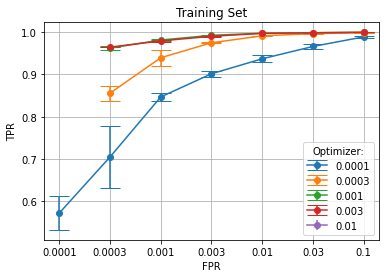

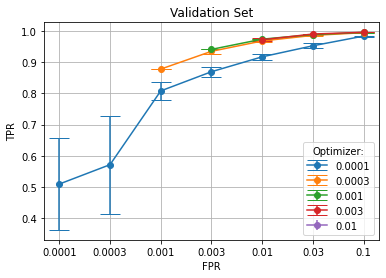

In [11]:
folder = "."
training_files = [x for x in os.listdir(folder) if x.endswith("training.json")]
validation_files = [x for x in os.listdir(folder) if x.endswith("validation.json")]

def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[1]

metrics_train = read_cv_metrics_folder('.', key_extractor, training_filter)
metrics_val = read_cv_metrics_folder('.', key_extractor, validation_filter)

TITLE = "Optimizer:"
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [12]:
model_config = {
    "vocab_size": 50002,
    "maxlen": 512,
    "chunk_size": 64,
    "dModel": 64,
    "nHeads": 8,
    "dHidden": 256,
    "nLayers": 2,
    "numClasses": 1,
    "hiddenNeurons": [
        64
    ],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False
}

data_splits = read_cv_data_splits(".")

existing_pickle = os.path.join(folder, "roc_metrics_val.pkl")
if os.path.exists(existing_pickle):
    roc_metrics_val = pickle.load(open(existing_pickle, "rb"))
else:
    roc_metrics_val = get_model_rocs(
        run_types=RUN_TYPES,
        model_class=TransformerEncoderChunks,
        model_config=model_config,
        data_splits=data_splits,
    )
    pickle.dump(roc_metrics_val, open(existing_pickle, "wb"))

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(roc_metrics_val)

,0.0001,0.0003,0.0010,0.0030,0.0100,0.0300,0.1000,0.3000
0.0100,0.000100,0.000300,0.001000,0.003000,0.010000,0.030000,0.100000,0.300000
0.0030,0.440634,0.542386,0.585115,0.630184,0.651056,0.670332,0.696988,0.766084
0.0010,0.580719,0.731924,0.876470,0.936507,0.973903,0.988416,0.995121,0.998911
0.0003,0.358746,0.688267,0.862986,0.932446,0.966805,0.985812,0.994519,0.999048
0.0001,0.518008,0.610702,0.798012,0.872499,0.915763,0.953002,0.984315,0.996638


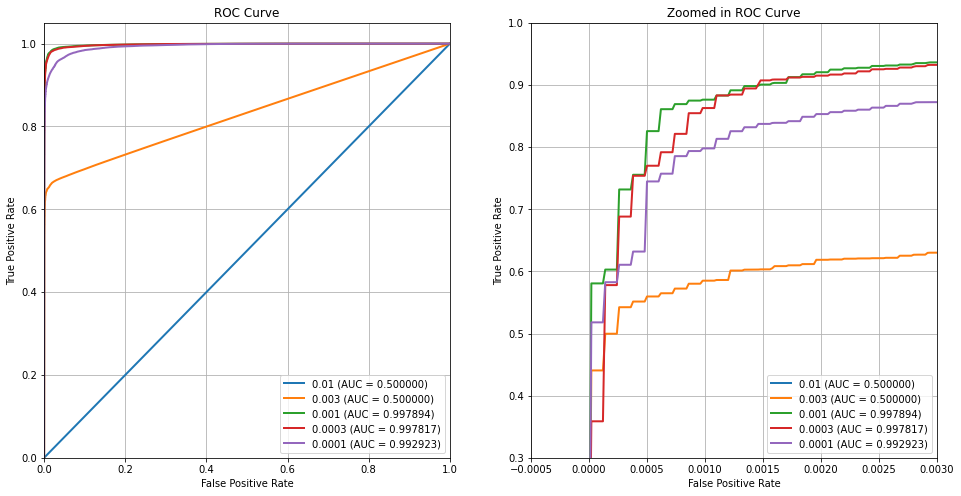

In [13]:
df, axs_val = report_alligned_metrics(base_fpr_val, tprs_mean_val, None, roc_metrics_val, xlim=[-0.0005, 0.003], ylim=[0.3, 1.0])
df

## Test set ROCs

In [14]:
xtestpath = os.path.join(REPO_ROOT, r"data\data_filtered\speakeasy_testset_BPE_50k\speakeasy_vocab_size_50000_maxlen_512_x.npy")
X_test = np.load(xtestpath)
ytestpath = os.path.join(REPO_ROOT, r"data\data_filtered\speakeasy_testset_BPE_50k\speakeasy_y.npy")
y_test = np.load(ytestpath)

splits = 3
data_splits = [{"X_test": X_test, "y_test": y_test}]*splits

existing_pickle = os.path.join(folder, "roc_metrics_test.pkl")
if os.path.exists(existing_pickle):
    metrics = pickle.load(open(existing_pickle, "rb"))
else:
    metrics = get_model_rocs(
        run_types=RUN_TYPES,
        model_class=TransformerEncoderChunks,
        model_config=model_config,
        data_splits=data_splits,
    )
    pickle.dump(metrics, open(existing_pickle, "wb"))

base_fpr, tprs_mean, tprs_std = allign_metrics(metrics)

,0.0001,0.0003,0.0010,0.0030,0.0100,0.0300,0.1000,0.3000
0.0100,0.000100,0.000300,0.001000,0.003000,0.010000,0.030000,0.100000,0.300000
0.0030,0.147362,0.333469,0.367911,0.424872,0.527811,0.581094,0.630270,0.743057
0.0010,0.149704,0.393101,0.526463,0.656174,0.762523,0.829026,0.887270,0.953348
0.0003,0.188592,0.361020,0.530646,0.662200,0.750115,0.838739,0.890496,0.960261
0.0001,0.136871,0.339998,0.426105,0.525329,0.630579,0.728641,0.826616,0.928108


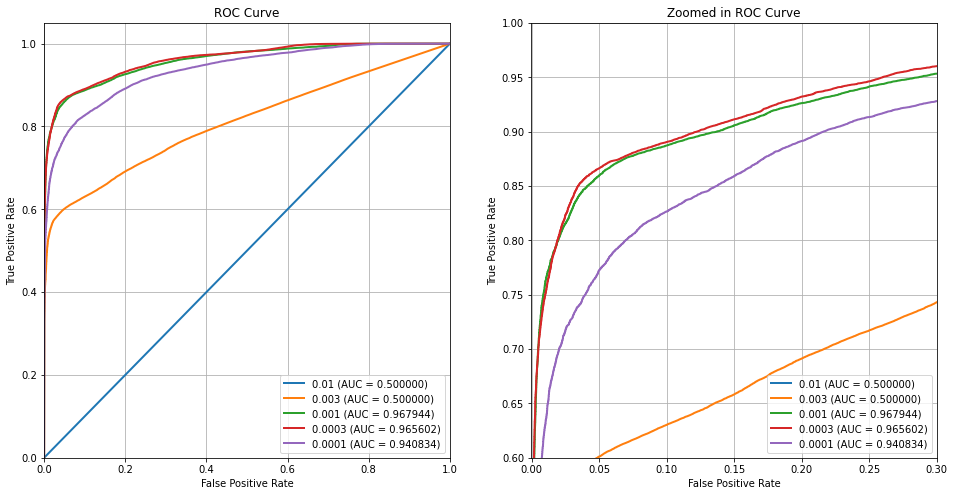

In [15]:
df, axs_test = report_alligned_metrics(base_fpr, tprs_mean, None, metrics)
df

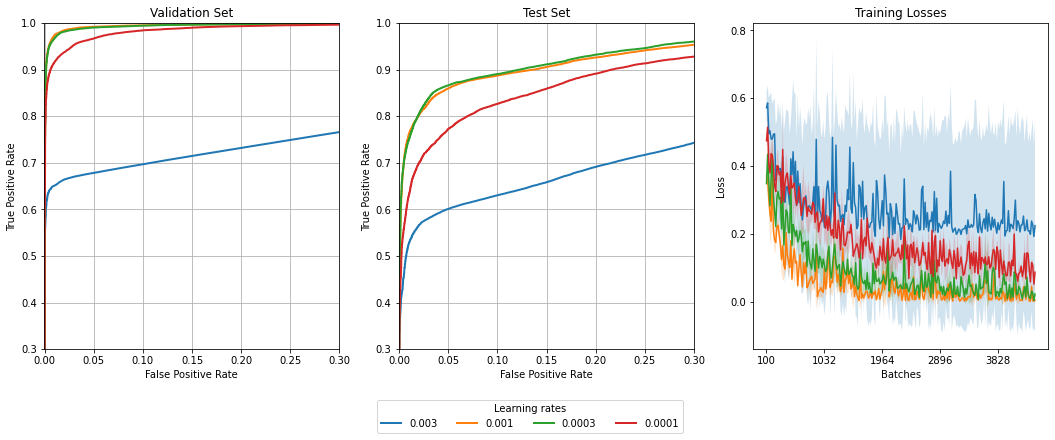

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 0.01:
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], model_name=key, ax=axs[0], ylim=[0.3,1], xlim=[-0.0005, 0.3])
    plot_roc_curve(base_fpr, tprs_mean[key], model_name=key, ax=axs[1], ylim=[0.3,1], xlim=[-0.0005, 0.3])

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

plot_losses(RUN_TYPES, ax=axs[2], skip_types=[0.01])
#axs[2].legend(loc='upper right', title="Learning rate")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title="Learning rates", bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')